In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec

from scipy import optimize

In [2]:
# Plotting style
default_cmap = "viridis"
figure_size  = 10, 5
font_size    = 16

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size
plt.rcParams[  "image.cmap"   ] =   default_cmap

plt.style.use(plt.style.available[10])

#set number of bins
nbins = 100

# 1. Import data

In [3]:
region = 'Csphotopeak'
df = pd.HDFStore('pmaps_corrected_{}_6206.h5'.format(region))['']

In [4]:
df.head()

,event,peak,nslices,nhits,noqhits,time,s1e,t0,rmax,x0,y0,z0,q0,e0,x,y,z,q,e
0,416,0,17,259,9261,0.0,142.078461,596.150378,0.0,-49.071080,-8.452012,61.065285,9231.001953,188439.78125,-48.726095,-8.381459,61.080067,9218.973028,164422.266338
1,638,0,25,293,10057,0.0,141.422714,494.007093,0.0,-138.894033,10.033711,165.153809,7902.346680,153924.96875,-139.061882,10.078133,165.194040,8656.621752,156114.460929
2,1047,0,22,299,11537,0.0,156.287827,519.870817,0.0,-5.123952,-20.835895,138.134109,9009.829102,180730.65625,-5.496032,-20.721798,138.140157,9402.072288,162037.707532
3,1055,0,24,159,3585,0.0,195.207336,454.107072,0.0,-25.106869,81.592038,208.602814,3590.298340,74971.40625,-24.757352,81.415924,208.634541,4065.205362,74622.343744
4,1055,1,14,163,2623,0.0,195.207336,454.107072,0.0,-68.818702,47.199135,246.855606,4272.459473,84634.53125,-69.006787,47.306320,246.853478,4738.999676,82745.972983


# 2. Corrected energy spectra overview

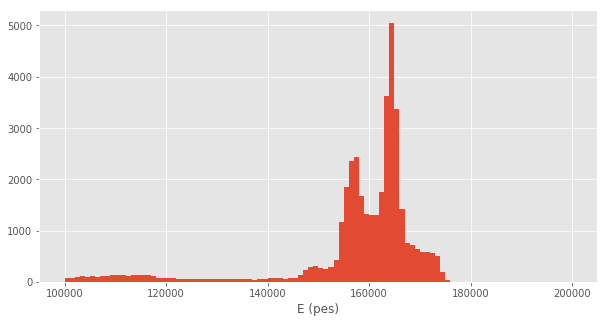

In [6]:
Emax = 200e3
Emin = 100e3

df['e'].hist(bins=nbins, range = (Emin, Emax));
plt.xlabel('E (pes)', fontsize=12);

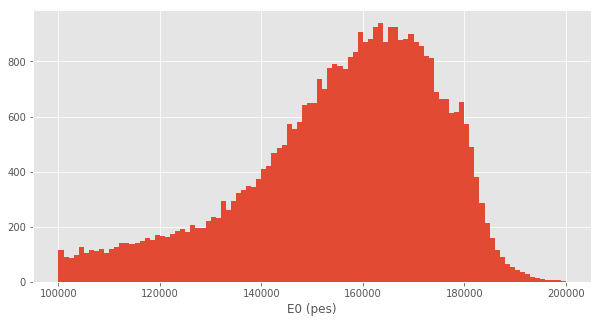

In [5]:
df['e0'].hist(bins=nbins, range = (Emin, Emax));
plt.xlabel('E0 (pes)', fontsize=12);

/home/gonzalo/anaconda3/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/numpy/lib/histograms.py:720: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gonzalo/anaconda3/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/numpy/lib/histograms.py:721: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


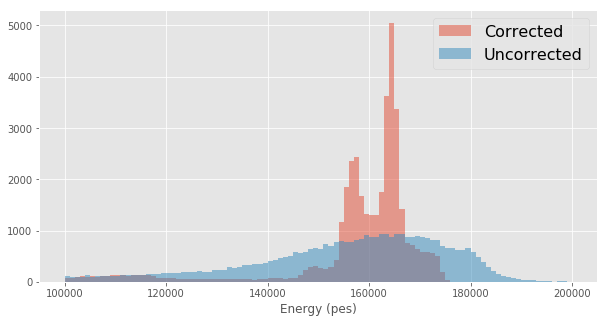

In [6]:
plt.hist(df['e'] , bins = nbins, range=(Emin, Emax), alpha=.5, label='Corrected' );
plt.hist(df['e0'], bins = nbins, range=(Emin, Emax), alpha=.5, label='Uncorrected' );
plt.legend(fontsize = 16);
plt.xlabel('Energy (pes)', fontsize=12);

# 3. Select region

In [7]:
Emax = 170e3
Emin = 160e3

In [8]:
df = df[(df.e<Emax) & (df.e>Emin)]

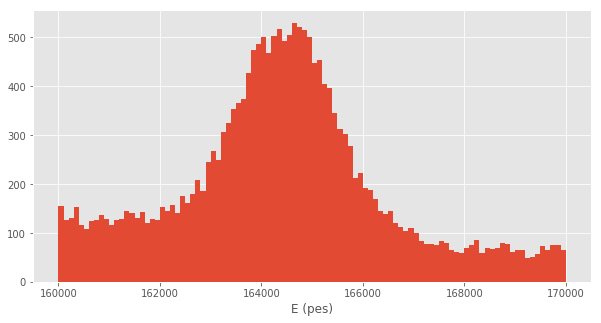

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

ydata, xdata, __ = ax.hist(df['e'], bins=nbins, range = (Emin,Emax));
plt.xlabel('E (pes)', fontsize=12);

# 4. Fitting photopeak

We perform a gaussian fit for the photopeak and assume a linear fit for background

$$F(E) = A e^{-(E-E_{ph})^2/2\sigma^2} + m(E-E_{min}) + c$$

In [10]:
def F(E, Eph, sig, A, m, c):
    return A * np.e**(-(E-Eph)**2/(2*sig**2)) + m*(E-Emin) + c

def chisq(F, popt, xdata, ydata):
    return np.sum((F(xdata, *popt)-ydata)**2/((len(xdata)-len(popt))*ydata))

In [11]:
xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

guess = [np.mean(df['e']), np.std(df['e']), np.max(ydata), -1, np.mean(ydata)]
popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata))

Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]

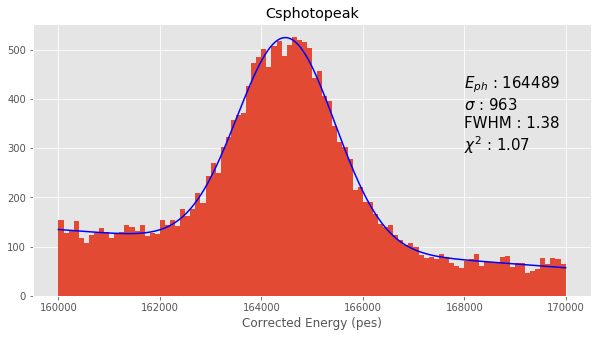

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(df['e'], bins=nbins);
E = np.linspace(Emin, Emax, 2*nbins);
ax.plot(E, F(E, *popt), color = 'b');

t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2)) + 
     "\n" + r"$\chi^2$ : {}".format(round(chisq(F, popt, xdata, ydata),2))) 

ax.text(168000, 300, s = t, fontsize = 15);
ax.set_xlabel('Corrected Energy (pes)');
ax.set_title('{}'.format(region));

In [13]:
print('Extrapolated FWHM:',sig/Eph * 235 * (662/2458)**.5)

Extrapolated FWHM: 0.7144117999852195


# 5. Searching correlations

## 5.1. Corrected Energy correlations

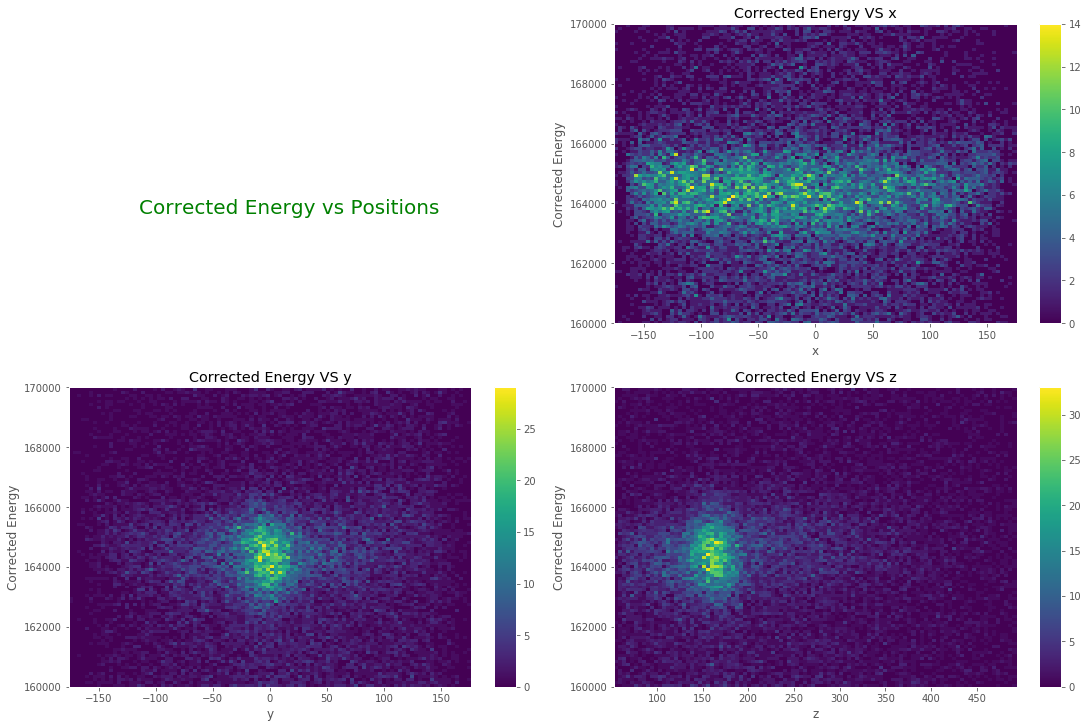

In [14]:
fig_ep = plt.figure(figsize =[15, 10] ,constrained_layout=True)

gs_ep = gridspec.GridSpec(2, 2, figure=fig_ep)

textpos = gs_ep[0, 0].get_position(fig_ep).get_points()
plt.figtext(textpos[0,0], (textpos[0,1] + textpos[1, 1])/2., 
            s='Corrected Energy vs Positions', figure=fig_ep, fontsize=20, color='green')

ax_ex = fig_ep.add_subplot(gs_ep[0, 1])
hist_ex = ax_ex.hist2d(df['x'], df['e'] , bins=nbins);
ax_ex.set_xlabel('x');
ax_ex.set_ylabel('Corrected Energy');
ax_ex.set_title('Corrected Energy VS x');
cbar_ex = fig_ep.colorbar(hist_ex[3], ax = ax_ex)

ax_ey = fig_ep.add_subplot(gs_ep[1, 0])
hist_ey = ax_ey.hist2d(df['y'], df['e'] , bins=nbins);
ax_ey.set_xlabel('y');
ax_ey.set_ylabel('Corrected Energy');
ax_ey.set_title('Corrected Energy VS y');
cbar_ey = fig_ep.colorbar(hist_ey[3], ax = ax_ey)

ax_ez = fig_ep.add_subplot(gs_ep[1, 1])
hist_ez = ax_ez.hist2d(df['z'], df['e'] , bins=nbins);
ax_ez.set_xlabel('z');
ax_ez.set_ylabel('Corrected Energy');
ax_ez.set_title('Corrected Energy VS z');
cbar_ez = fig_ep.colorbar(hist_ez[3], ax = ax_ez)

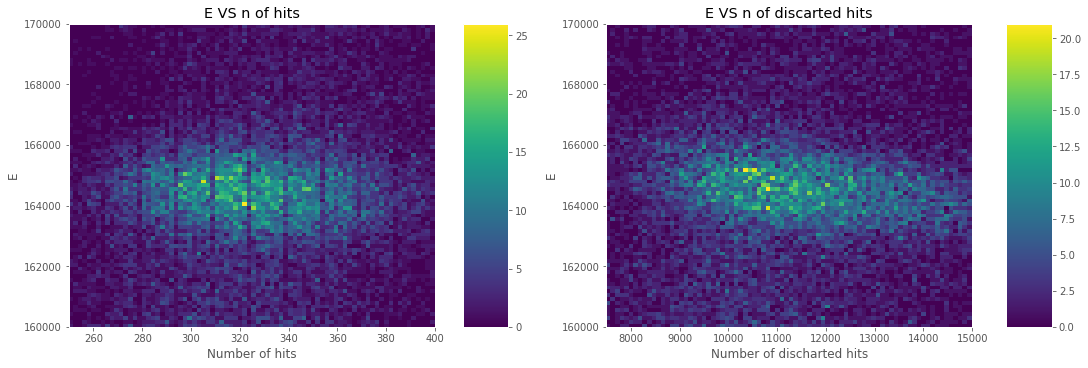

In [15]:
fig_e = plt.figure(figsize=[15, 5], constrained_layout=True)

gs_e = gridspec.GridSpec(1, 2, figure=fig_e)

ax_enhits = fig_e.add_subplot(gs_e[0])
hist_enhits = ax_enhits.hist2d(df['nhits'], df['e'] , bins=.8*nbins, range=((250, 400),(Emin, Emax)));
ax_enhits.set_xlabel('Number of hits');
ax_enhits.set_ylabel('E');
ax_enhits.set_title('E VS n of hits');
cbar_enhits = fig_e.colorbar(hist_enhits[3], ax = ax_enhits)

ax_enoqhits = fig_e.add_subplot(gs_e[1])
hist_enoqhits = ax_enoqhits.hist2d(df['noqhits'], df['e'] , bins=.8*nbins, range=((7.5e3, 15e3), (Emin, Emax)));
ax_enoqhits.set_xlabel('Number of discharted hits');
ax_enoqhits.set_ylabel('E');
ax_enoqhits.set_title('E VS n of discarted hits');
cbar_enoqhits = fig_e.colorbar(hist_enoqhits[3], ax = ax_enoqhits)

### 5.1.1. E vs Number of Slices

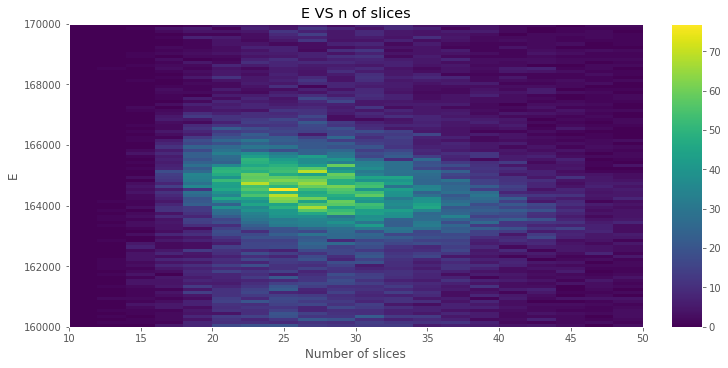

In [16]:
fig_enslices = plt.figure(constrained_layout=True)

gs_enslices = gridspec.GridSpec(1, 1, figure=fig_enslices)

ax_enslices = fig_enslices.add_subplot(gs_enslices[0, 0])
hist_enslices = ax_enslices.hist2d(df['nslices'], df['e'] , bins=[.2*nbins, nbins], range=((10, 50),(Emin, Emax)));
ax_enslices.set_xlabel('Number of slices');
ax_enslices.set_ylabel('E');
ax_enslices.set_title('E VS n of slices');
cbar_enslices = fig_enslices.colorbar(hist_enslices[3], ax = ax_enslices)

In [17]:
## Profile construction
cut    = 100 #cut for the number of entries in each slice
n_merg = 5   #size of the group of slices to merge

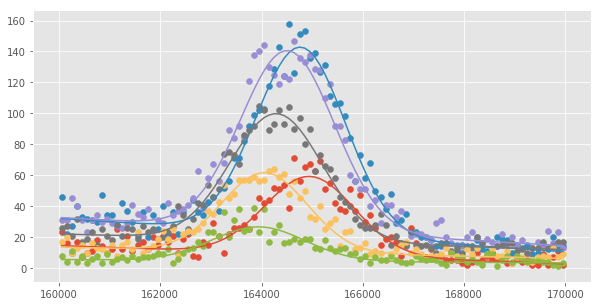

In [18]:
nslices_raw = np.unique(df['nslices'])

#Cut in number of slices
nslices = []
for nsl in nslices_raw:
    if len(df[df.nslices == nsl])<cut:
        continue
    else: nslices.append(nsl)
nslices = np.array(nslices)

nslices_merged = np.array([nslices[n_merg*i:n_merg*(i+1)] for i in range(0, int(len(nslices)/n_merg))])

profile = pd.DataFrame(columns=['nslices', 'Eph', 'sig', 'chisq'])
for nslices in nslices_merged:
    cdf = df[(df.nslices >= nslices[0]) & ((df.nslices <= nslices[-1]))]
    
    #Fitting
    ydata, xdata = np.histogram(cdf['e'], bins=nbins, range = (Emin,Emax))
    xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

    guess = [np.mean(cdf['e']), np.std(cdf['e']), np.max(ydata), -1, np.mean(ydata)]
    popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata))
    chi = chisq(F, popt, xdata, ydata)
    
    Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]
    
    nsl = np.sum(nslices)/len(nslices)
    profile = profile.append({'nslices': nsl, 'Eph': Eph, 'sig': sig, 'chisq': chi}, ignore_index=True)
    
    plt.scatter(xdata, ydata)
    plt.plot(xdata, F(xdata, *popt))

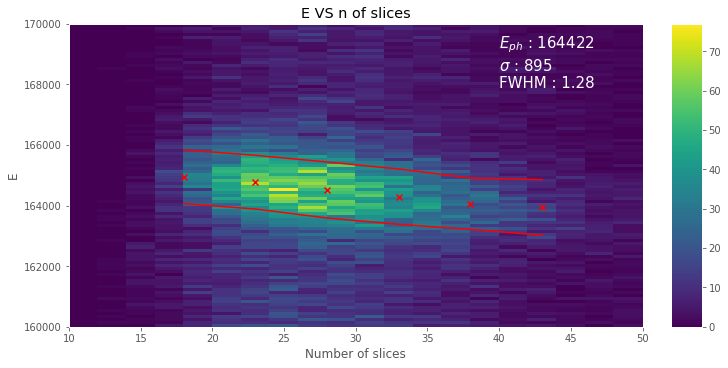

In [19]:
fig_enslices = plt.figure(constrained_layout=True)

gs_enslices = gridspec.GridSpec(1, 1, figure=fig_enslices)

ax_enslices = fig_enslices.add_subplot(gs_enslices[0, 0])
hist_enslices = ax_enslices.hist2d(df['nslices'], df['e'] , bins=[.2*nbins, nbins], range=((10, 50),(Emin, Emax)));
ax_enslices.set_xlabel('Number of slices');
ax_enslices.set_ylabel('E');
ax_enslices.set_title('E VS n of slices');
cbar_enslices = fig_enslices.colorbar(hist_enslices[3], ax = ax_enslices)

ax_enslices.scatter(profile['nslices'], profile['Eph'], marker='x', color='r');

ax_enslices.plot(profile['nslices'], profile['Eph'] + profile['sig'], color='r');
ax_enslices.plot(profile['nslices'], profile['Eph'] - profile['sig'], color='r');


Eph = profile['Eph'].mean()
sig = profile['sig'].mean()
t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2))) 

ax_enslices.text(40, 168e3, s = t, fontsize = 15, color='white');

In [20]:
profile

,nslices,Eph,sig,chisq
0,18.0,164953.377738,886.639662,1.621811
1,23.0,164772.458007,886.928267,1.133399
2,28.0,164514.665399,923.651651,1.140511
3,33.0,164294.111089,913.822971,0.753033
4,38.0,164062.073304,846.617459,1.068709
5,43.0,163939.895710,918.068998,1.252351


In [21]:
Eph = profile['Eph'].mean()
sig = profile['sig'].mean()

In [22]:
print('Extrapolated FWHM:', sig/Eph * 235 * (662/2458)**.5)

Extrapolated FWHM: 0.6645537173881788


## 5.2. Other Correlations

### 5.2.1 Number of slices

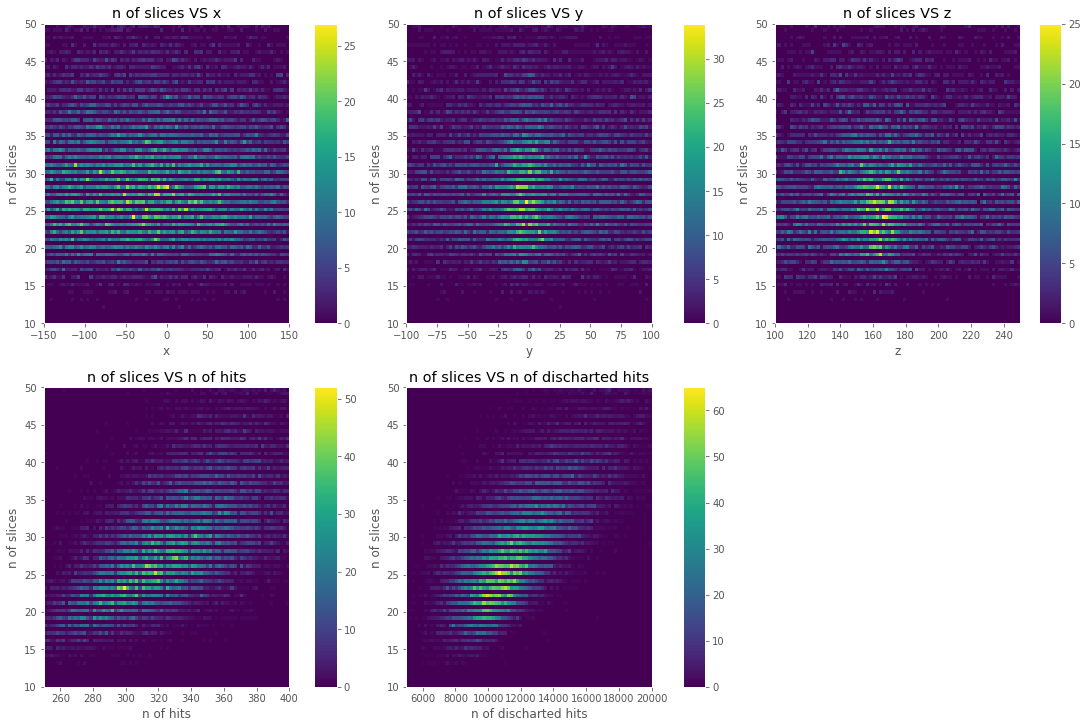

In [23]:
fig_nsl = plt.figure(figsize=[15, 10], constrained_layout=True)

gs_nsl = gridspec.GridSpec(2, 3, figure=fig_nsl)

ax_nslx = fig_nsl.add_subplot(gs_nsl[0,0])
hist_nslx = ax_nslx.hist2d(df['x'], df['nslices'] , bins=.8*nbins, range=((-150, 150),(10, 50)));
ax_nslx.set_xlabel('x');
ax_nslx.set_ylabel('n of slices');
ax_nslx.set_title('n of slices VS x');
cbar_nslx = fig_e.colorbar(hist_nslx[3], ax = ax_nslx)

ax_nsly = fig_nsl.add_subplot(gs_nsl[0,1])
hist_nsly = ax_nsly.hist2d(df['y'], df['nslices'] , bins=.8*nbins, range=((-100, 100),(10, 50)));
ax_nsly.set_xlabel('y');
ax_nsly.set_ylabel('n of slices');
ax_nsly.set_title('n of slices VS y');
cbar_nsly = fig_nsl.colorbar(hist_nsly[3], ax = ax_nsly)

ax_nslz = fig_nsl.add_subplot(gs_nsl[0,2])
hist_nslz= ax_nslz.hist2d(df['z'], df['nslices'] , bins=.8*nbins, range=((100, 250),(10, 50)));
ax_nslz.set_xlabel('z');
ax_nslz.set_ylabel('n of slices');
ax_nslz.set_title('n of slices VS z');
cbar_nslz = fig_nsl.colorbar(hist_nslz[3], ax = ax_nslz);

ax_nslnh = fig_nsl.add_subplot(gs_nsl[1,0])
hist_nslnh= ax_nslnh.hist2d(df['nhits'], df['nslices'] , bins=.8*nbins, range=((250, 400),(10, 50)));
ax_nslnh.set_xlabel('n of hits');
ax_nslnh.set_ylabel('n of slices');
ax_nslnh.set_title('n of slices VS n of hits');
cbar_nslnh= fig_nsl.colorbar(hist_nslnh[3], ax = ax_nslnh);

ax_nslnoh = fig_nsl.add_subplot(gs_nsl[1,1])
hist_nslnoh= ax_nslnoh.hist2d(df['noqhits'], df['nslices'] , bins=.8*nbins, range=((5e3, 20e3),(10, 50)));
ax_nslnoh.set_xlabel('n of discharted hits');
ax_nslnoh.set_ylabel('n of slices');
ax_nslnoh.set_title('n of slices VS n of discharted hits');
cbar_nslnoh= fig_nsl.colorbar(hist_nslnoh[3], ax = ax_nslnoh);

# 6. Other distributions

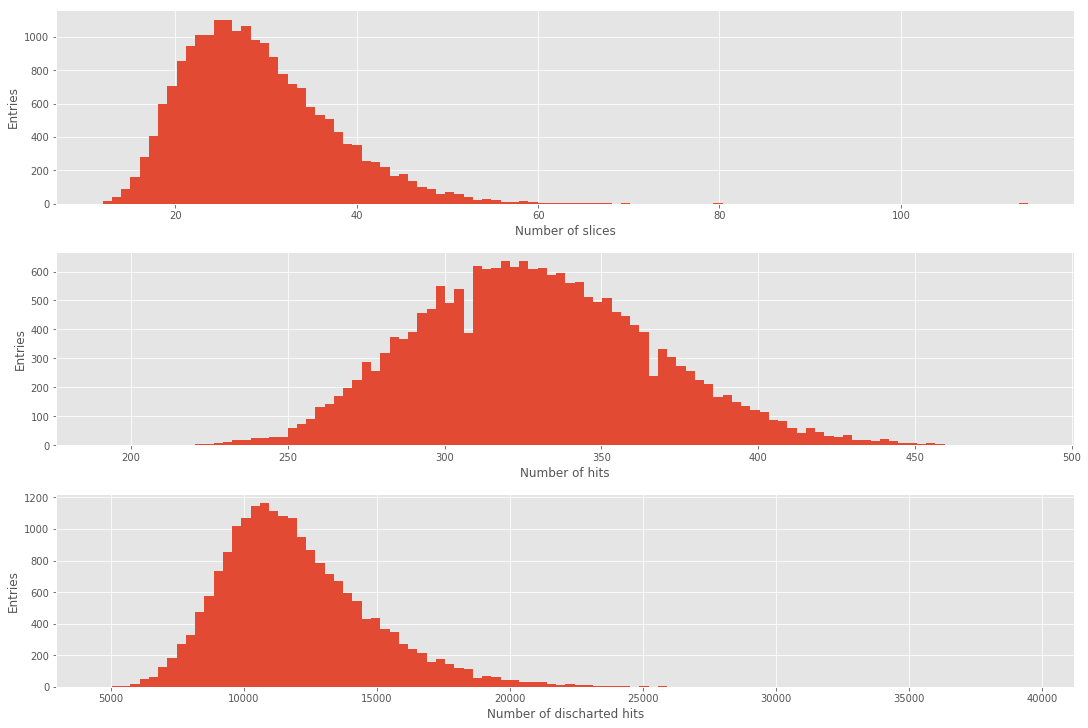

In [24]:
fig_d = plt.figure(figsize=[15, 10], constrained_layout=True)

gs_d = gridspec.GridSpec(3, 1, figure=fig_d)

ax_nsl = fig_d.add_subplot(gs_d[0]);
hist_nsl = ax_nsl.hist(df['nslices'] , bins=nbins);
ax_nsl.set_xlabel('Number of slices');
ax_nsl.set_ylabel('Entries');

ax_nh = fig_d.add_subplot(gs_d[1]);
hist_nh = ax_nh.hist(df['nhits'] , bins=nbins);
ax_nh.set_xlabel('Number of hits');
ax_nh.set_ylabel('Entries');

ax_noh = fig_d.add_subplot(gs_d[2]);
hist_noh = ax_noh.hist(df['noqhits'] , bins=nbins);
ax_noh.set_xlabel('Number of discharted hits');
ax_noh.set_ylabel('Entries');

# 7. Fiducial cuts

## 7.1. Fit

In [25]:
R_fid = 160
z_fid_max = 550
z_fid_min = 50

In [26]:
fid_df = df[(df.x0**2 + df.y0**2 < R_fid**2) & (df.z0 < z_fid_max) & (df.z0 > z_fid_min)]

In [27]:
ydata, xdata = np.histogram(fid_df['e'], bins=nbins, range=(Emin, Emax))
xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

guess = [np.mean(fid_df['e']), np.std(fid_df['e']), np.max(ydata), -1, np.mean(ydata)]
popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata))

Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]

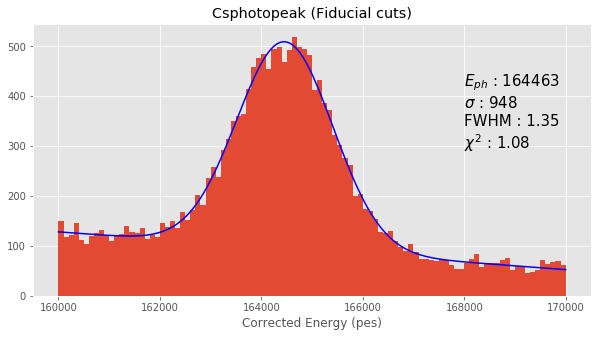

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(fid_df['e'], bins=nbins);
E = np.linspace(Emin, Emax, 2*nbins);
ax.plot(E, F(E, *popt), color = 'b');

t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2)) + 
     "\n" + r"$\chi^2$ : {}".format(round(chisq(F, popt, xdata, ydata),2))) 

ax.text(168000, 300, s = t, fontsize = 15);
ax.set_xlabel('Corrected Energy (pes)');
ax.set_title('{} (Fiducial cuts)'.format(region));

In [29]:
print('Extrapolated FWHM:',sig/Eph * 235 * (662/2458)**.5)

Extrapolated FWHM: 0.7030696677262213


## 7.2. Number of slices profile

In [30]:
## Profile construction
cut    = 100 #cut for the number of entries in each slice
n_merg = 5   #size of the group of slices to merge

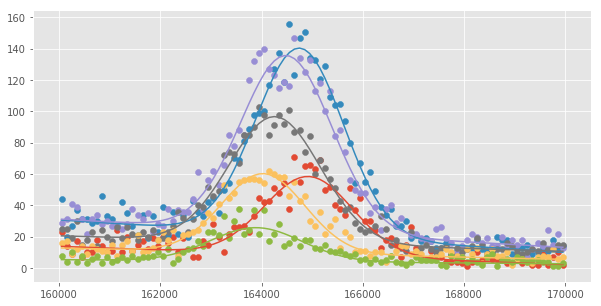

In [31]:
nslices_raw = np.unique(fid_df['nslices'])

#Cut in number of slices
nslices = []
for nsl in nslices_raw:
    if len(df[df.nslices == nsl])<cut:
        continue
    else: nslices.append(nsl)
nslices = np.array(nslices)

nslices_merged = np.array([nslices[n_merg*i:n_merg*(i+1)] for i in range(0, int(len(nslices)/n_merg))])

profile = pd.DataFrame(columns=['nslices', 'Eph', 'sig', 'chisq'])
for nslices in nslices_merged:
    cdf = fid_df[(fid_df.nslices >= nslices[0]) & ((fid_df.nslices <= nslices[-1]))]
    
    #Fitting
    ydata, xdata = np.histogram(cdf['e'], bins=nbins, range = (Emin,Emax))
    xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

    guess = [np.mean(cdf['e']), np.std(cdf['e']), np.max(ydata), -1, np.mean(ydata)]
    popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata))
    chi = chisq(F, popt, xdata, ydata)
    
    Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]
    
    nsl = np.sum(nslices)/len(nslices)
    profile = profile.append({'nslices': nsl, 'Eph': Eph, 'sig': sig, 'chisq': chi}, ignore_index=True)
    
    plt.scatter(xdata, ydata)
    plt.plot(xdata, F(xdata, *popt))

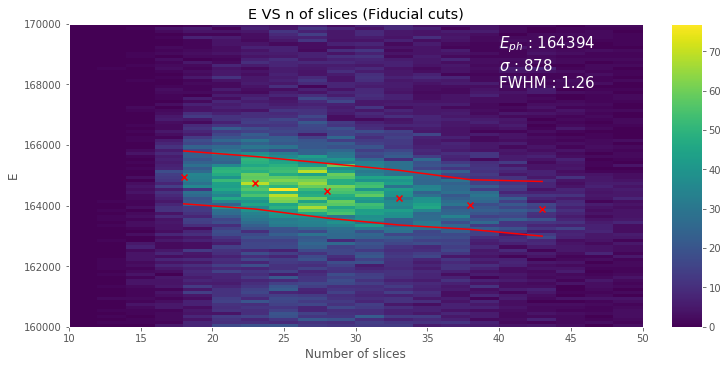

In [32]:
fig_enslices = plt.figure(constrained_layout=True)

gs_enslices = gridspec.GridSpec(1, 1, figure=fig_enslices)

ax_enslices = fig_enslices.add_subplot(gs_enslices[0, 0])
hist_enslices = ax_enslices.hist2d(df['nslices'], df['e'] , bins=[.2*nbins, nbins], range=((10, 50),(Emin, Emax)));
ax_enslices.set_xlabel('Number of slices');
ax_enslices.set_ylabel('E');
ax_enslices.set_title('E VS n of slices (Fiducial cuts)');
cbar_enslices = fig_e.colorbar(hist_enslices[3], ax = ax_enslices)

ax_enslices.scatter(profile['nslices'], profile['Eph'], marker='x', color='r');

ax_enslices.plot(profile['nslices'], profile['Eph'] + profile['sig'], color='r');
ax_enslices.plot(profile['nslices'], profile['Eph'] - profile['sig'], color='r');


Eph = profile['Eph'].mean()
sig = profile['sig'].mean()
t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2))) 

ax_enslices.text(40, 168e3, s = t, fontsize = 15, color='white');

In [33]:
Eph = profile['Eph'].mean()
sig = profile['sig'].mean()

In [34]:
print('Extrapolated FWHM:', sig/Eph * 235 * (662/2458)**.5)

Extrapolated FWHM: 0.6513715009070046
